In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer

In [12]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


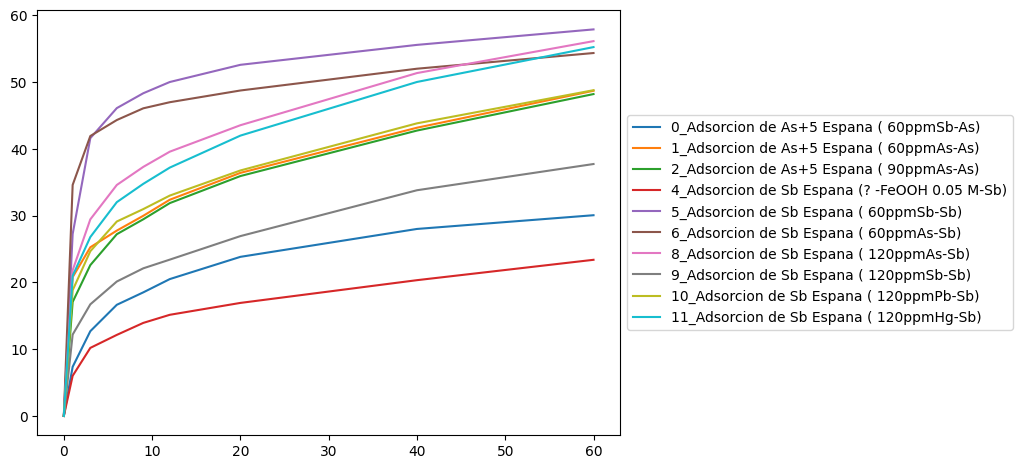

In [13]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [14]:
import numpy as np

class KineticMonteCarlo:
    def __init__(self, lattice_size, T, processes, time_array, time_factor = 1e-7):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.processes = processes  # dict: procesos y sus parámetros
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {p: 0 for p in processes.keys()}
        self.events_history = {p: [] for p in processes.keys()}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def calculate_transition_rates(self, site):
        rates = {}
        n_ij = self.count_occupied_neighbors(site)

        if "adsorption" in self.processes:
            e_ads = self.processes["adsorption"]["e_ads"]
            e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
            E_ads = e_int_abs * n_ij + e_ads
            k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
            rates["adsorption"] = k_ads

        if "desorption" in self.processes:
            e_des = self.processes["desorption"]["e_des"]
            e_int_des = self.processes["desorption"].get("e_int_des", 0)
            E_des = e_int_des * n_ij + e_des
            k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
            rates["desorption"] = k_des

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))
            rates["diffusion"] = k_diff

        return rates

    def select_event(self, rates):
        total_propensity = sum(rates.values())
        r = np.random.rand() * total_propensity
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None  # shouldn't happen

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event_type = self.select_event(rates)
            if event_type == "adsorption":
                self.lattice[site] = 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
            elif event_type == "diffusion":
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.events_count[event_type] += 1
            for key in self.events_history:
                self.events_history[key].append(self.events_count[key])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy
    
    def reset_lattice(self):
        self.lattice = np.zeros((self.lattice_size, self.lattice_size))
        self.occupancy = {t: None for t in self.time_array} 



In [15]:
class KMCModelOptimizer:
    def __init__(self, exp_data, param_ranges, n_calls=200):
        self.exp_data = exp_data
        self.param_ranges = param_ranges
        self.n_calls = n_calls
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = tqdm(total=self.n_calls, desc="Optimización Bayesiana en Progreso", position=0, ncols=100)

    def loss_function(self, params):
        # Desempaquetar parámetros de acuerdo a lo que se pasa
        param_dict = {}
        param_names = list(self.param_ranges.keys())

        for i, param_name in enumerate(param_names):
            param_dict[param_name] = params[i]

        # Construir el diccionario de procesos
        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {"e_ads": param_dict["e_ads"], "e_int_abs": param_dict.get("e_int_abs", 0.1)}
        if 'e_des' in param_dict:
            processes["desorption"] = {"e_des": param_dict["e_des"], "e_int_des": param_dict.get("e_int_des", 0.7)}
        if 'e_diff' in param_dict:
            processes["diffusion"] = {"e_diff": param_dict["e_diff"]}

        # Ejecutar el modelo KMC
        kmc_model = KineticMonteCarlo(
            lattice_size=int(param_dict['lattice_size']), T=param_dict['T'],
            processes=processes,
            time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
        )

        kmc_model.reset_lattice()
        kmc_model.run_simulation()

        # Calcular error
        simulated_data = np.array(list(kmc_model.occupancy.values()))
        error = np.mean((simulated_data - self.exp_data) ** 2)

        # Actualizar mejores parámetros si se encuentra un menor error
        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        # Actualizar la barra de progreso con información relevante
        self.progress_bar.set_postfix({
            "Mejor error": f"{self.best_error:.6f}",
            "Parámetros óptimos": f"{self.best_params}",
            "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
        })
        self.progress_bar.update(1)

        return error

    def optimize(self):
        # Definir el espacio de búsqueda dinámicamente solo con los parámetros presentes
        space = []
        param_names = list(self.param_ranges.keys())

        for param_name in param_names:
            if param_name == 'e_ads' and 'e_ads' in self.param_ranges:
                space.append(Real(self.param_ranges['e_ads'][0], self.param_ranges['e_ads'][1], name="e_ads"))
            elif param_name == 'e_des' and 'e_des' in self.param_ranges:
                space.append(Real(self.param_ranges['e_des'][0], self.param_ranges['e_des'][1], name="e_des"))
            elif param_name == 'e_diff' and 'e_diff' in self.param_ranges:
                space.append(Real(self.param_ranges['e_diff'][0], self.param_ranges['e_diff'][1], name="e_diff"))
            elif param_name == 'e_int_abs' and 'e_int_abs' in self.param_ranges:
                space.append(Real(self.param_ranges['e_int_abs'][0], self.param_ranges['e_int_abs'][1], name="e_int_abs"))
            elif param_name == 'e_int_des' and 'e_int_des' in self.param_ranges:
                space.append(Real(self.param_ranges['e_int_des'][0], self.param_ranges['e_int_des'][1], name="e_int_des"))
            elif param_name == 'lattice_size' and 'lattice_size' in self.param_ranges:
                space.append(Integer(self.param_ranges['lattice_size'][0], self.param_ranges['lattice_size'][1], name="lattice_size"))
            elif param_name == 'T' and 'T' in self.param_ranges:
                space.append(Real(self.param_ranges['T'][0], self.param_ranges['T'][1], name="T"))

        # Iniciar optimización
        start_time = time.time()
        result = gp_minimize(self.loss_function, space, n_calls=self.n_calls, random_state=42)
        self.progress_bar.close()

        # Mostrar resultados finales
        end_time = time.time()
        print("\n✅ Optimización completada")
        print("🔹 Parámetros óptimos encontrados:", self.best_params)
        print("🔹 Error mínimo encontrado:", self.best_error)
        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        
        # Pasar los mejores parámetros al modelo KMC
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if self.best_params:
            # Construir el diccionario de procesos con los mejores parámetros
            processes = {}
            if 'e_ads' in self.best_params:
                processes["adsorption"] = {"e_ads": self.best_params["e_ads"], "e_int_abs": self.best_params.get("e_int_abs", 0.1)}
            if 'e_des' in self.best_params:
                processes["desorption"] = {"e_des": self.best_params["e_des"], "e_int_des": self.best_params.get("e_int_des", 0.7)}
            if 'e_diff' in self.best_params:
                processes["diffusion"] = {"e_diff": self.best_params["e_diff"]}

            # Crear el modelo KMC con los mejores parámetros encontrados
            kmc_model = KineticMonteCarlo(
                lattice_size=int(self.best_params['lattice_size']), T=self.best_params['T'],
                processes=processes,
                time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
            )

            # Ejecutar la simulación con los mejores parámetros
            kmc_model.run_simulation()
            print(f"Modelo KMC ejecutado con los mejores parámetros: {self.best_params}")
        else:
            print("No se encontraron parámetros óptimos para ejecutar el modelo KMC.")


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_multiple_simulations(N, lattice_size, T, processes, time_array, exp_data):
    curves = []
    times = []

    for _ in range(N):
        kmc_model = KineticMonteCarlo(
            lattice_size=lattice_size, 
            T=T, 
            processes=processes,  # El diccionario de procesos se pasa tal cual
            time_array=time_array
        )
        kmc_model.reset_lattice()
        occupancy = kmc_model.run_simulation()
        curves.append(list(occupancy.values()))
        times.append(kmc_model.time_array)
    
    # Convertir a DataFrame para facilitar el procesamiento
    df = pd.DataFrame(curves)
    
    # Calcular media y desviación estándar
    mean_values = df.mean().to_numpy()
    std_values = df.std().to_numpy()

    # Imprimir valores medios y desviación estándar
    print("Mean values: ", mean_values)
    print("Standard deviation values: ", std_values)

    # Graficar los resultados
    plt.errorbar(time_array, mean_values, yerr=std_values, capsize=5, color='red', fmt='o', label='Mean values')
    plt.plot(time_array, exp_data, marker='o', label='Experimental data')
    plt.xlabel("Time")
    plt.ylabel("Percentage of occupied sites")
    plt.title("Adsorption over time")
    plt.legend()

    # Calcular el Error Cuadrático Medio (MSE)
    mse = np.mean((np.array(exp_data) - np.array(mean_values)) ** 2)
    print(f"Mean Squared Error (MSE): {mse}")



--- Optimizando para el Experimento: 0_Adsorcion de As+5 Espana ( 60ppmSb-As) ---


Optimización Bayesiana en Progreso:  26%|▎| 26/100 [29:17<1:23:22, 67.60s/it, Mejor error=2.077146, 
Optimización Bayesiana en Progreso:  42%|▍| 42/100 [26:01<35:56, 37.18s/it, Mejor error=1.056707, Pa
Optimización Bayesiana en Progreso: 100%|█| 100/100 [04:28<00:00,  2.69s/it, Mejor error=0.311016, P



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.06694873613235432, 'e_des': 0.13, 'e_diff': 0.3084529092362695, 'e_int_abs': 0.06407592192192697, 'e_int_des': 0.7797938867450083, 'lattice_size': np.int64(750), 'T': 304.0}
🔹 Error mínimo encontrado: 0.3110156674174753
⏳ Tiempo total de ejecución: 268.67 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.06694873613235432, 'e_des': 0.13, 'e_diff': 0.3084529092362695, 'e_int_abs': 0.06407592192192697, 'e_int_des': 0.7797938867450083, 'lattice_size': np.int64(750), 'T': 304.0}

--- Graficando ajuste para 0_Adsorcion de As+5 Espana ( 60ppmSb-As) ---


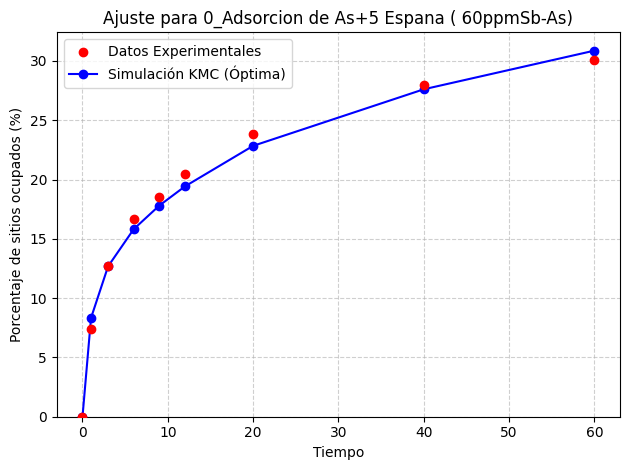


--- Optimizando para el Experimento: 1_Adsorcion de As+5 Espana ( 60ppmAs-As) ---


Optimización Bayesiana en Progreso:  15%|▏| 15/100 [00:23<02:04,  1.46s/it, Mejor error=6.934397, Pa

KeyboardInterrupt: 

In [18]:
import numpy as np
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm
import matplotlib.pyplot as plt # Asegúrate de importar matplotlib

# --- Asume que las siguientes clases y datos están definidos ---
# data: DataFrame con datos experimentales
# KineticMonteCarlo: Definición de la clase
# KMCModelOptimizer: Definición de la clase
# -------------------------------------------------------------

# Define el porcentaje de variabilidad para los rangos de parámetros (ajusta si es necesario)
variability_percentage = 0.3 # 10% de variabilidad

# Valores centrales de los parámetros (puedes ajustar estos puntos de partida o rangos)
central_processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.1, "e_int_des": 0.7},
    "diffusion": {"e_diff": 0.36}
}
central_T = 300
central_lattice_size = 70

# --- Almacena los resultados de todos los experimentos ---
all_results = []
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60]) # Asume que este es el array de tiempo para todos

# --- Itera sobre cada conjunto de datos experimentales ---
for i in range(len(data)):
    experiment_label = data.iloc[i]['Fuente(experimento)'] # Obtiene la etiqueta
    exp_data_points = data.iloc[i, :9].to_numpy() # Obtiene los puntos de datos (asumiendo las 9 primeras columnas)

    print(f"\n--- Optimizando para el Experimento: {experiment_label} ---")

    # --- Define los rangos de parámetros para la optimización actual ---
    param_ranges = {
        'e_ads': [central_processes["adsorption"]["e_ads"] * (1 - variability_percentage),
                  central_processes["adsorption"]["e_ads"] * (1 + variability_percentage)],
        'e_des': [central_processes["desorption"]["e_des"] * (1 - variability_percentage),
                  central_processes["desorption"]["e_des"] * (1 + variability_percentage)],
        'e_diff': [central_processes["diffusion"]["e_diff"] * (1 - variability_percentage),
                   central_processes["diffusion"]["e_diff"] * (1 + variability_percentage)],
        'e_int_abs': [central_processes["adsorption"]["e_int_abs"] * (1 - variability_percentage),
                      central_processes["adsorption"]["e_int_abs"] * (1 + variability_percentage)],
        'e_int_des': [central_processes["desorption"]["e_int_des"] * (1 - variability_percentage),
                      central_processes["desorption"]["e_int_des"] * (1 + variability_percentage)],
        'lattice_size': [150, 1000],  # Mantén o ajusta este rango
        'T': [297, 304]             # Mantén o ajusta este rango
    }

    # --- Ejecuta la optimización para la curva actual ---
    # n_calls puede necesitar ajuste según precisión vs tiempo
    optimizer = KMCModelOptimizer(exp_data_points, param_ranges, n_calls=100) # Usa exp_data_points actual
    optimizer.optimize() # Ejecuta la optimización e imprime resultados para esta curva

    # --- Almacena los mejores resultados para esta curva ---
    if optimizer.best_params:
        current_result = {
            'experiment': experiment_label,
            'best_params': optimizer.best_params,
            'min_error': optimizer.best_error
        }
        all_results.append(current_result)

        # --- Ejecuta UNA simulación KMC con los mejores parámetros y grafica ---
        print(f"\n--- Graficando ajuste para {experiment_label} ---")
        best_params_found = optimizer.best_params
        best_processes = {}
        if 'e_ads' in best_params_found:
             best_processes["adsorption"] = {"e_ads": best_params_found["e_ads"], "e_int_abs": best_params_found.get("e_int_abs", 0.1)} # Usa valor por defecto si no se encuentra
        if 'e_des' in best_params_found:
             best_processes["desorption"] = {"e_des": best_params_found["e_des"], "e_int_des": best_params_found.get("e_int_des", 0.7)} # Usa valor por defecto si no se encuentra
        if 'e_diff' in best_params_found:
             best_processes["diffusion"] = {"e_diff": best_params_found["e_diff"]}

        # Crea y ejecuta el modelo KMC UNA VEZ con los mejores parámetros
        kmc_model_optimal = KineticMonteCarlo(
            lattice_size=int(best_params_found['lattice_size']),
            T=best_params_found['T'],
            processes=best_processes,
            time_array=time_array
        )
        # kmc_model_optimal.reset_lattice() # No es necesario si se crea una nueva instancia
        occupancy_results = kmc_model_optimal.run_simulation() # Ejecuta la simulación
        simulated_data_points = list(occupancy_results.values()) # Obtiene los resultados

        # Grafica
        plt.figure() # Crea una nueva figura para cada gráfico
        plt.scatter(time_array, exp_data_points, color='red', label='Datos Experimentales', zorder=5) # Puntos experimentales
        plt.plot(time_array, simulated_data_points, marker='o', linestyle='-', color='blue', label='Simulación KMC (Óptima)') # Curva simulada
        plt.xlabel("Tiempo")
        plt.ylabel("Porcentaje de sitios ocupados (%)")
        plt.title(f"Ajuste para {experiment_label}")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(bottom=0) # Asegura que el eje Y empiece en 0
        plt.tight_layout()
        plt.show() # Muestra el gráfico

    else:
         print(f"La optimización no encontró parámetros para {experiment_label}")

# --- Imprime todos los resultados después del bucle ---
print("\n===========================================")
print("Resultados de Optimización para Todos los Experimentos:")
print("===========================================")
for result in all_results:
    print(f"Experimento: {result['experiment']}")
    print(f"  Mejores Parámetros: {result['best_params']}")
    print(f"  Error Mínimo (MSE): {result['min_error']:.6f}\n")

# Opcional: Convertir resultados a DataFrame
# results_df = pd.DataFrame(all_results)
# print(results_df)

\n--- Optimizing for Experiment: 0_Adsorcion de As+5 Espana ( 60ppmSb-As) ---


Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:52<00:00,  1.89it/s, Mejor error=0.366175, P



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.099, 'e_des': 0.09000000000000001, 'e_diff': 0.3719729190993185, 'e_int_abs': 0.07516680479041381, 'e_int_des': 0.63, 'lattice_size': np.int64(100), 'T': 280.0}
🔹 Error mínimo encontrado: 0.3661750795673917
⏳ Tiempo total de ejecución: 52.84 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.099, 'e_des': 0.09000000000000001, 'e_diff': 0.3719729190993185, 'e_int_abs': 0.07516680479041381, 'e_int_des': 0.63, 'lattice_size': np.int64(100), 'T': 280.0}
\n--- Plotting fit for 0_Adsorcion de As+5 Espana ( 60ppmSb-As) ---
Mean values:  [ 0.     10.1152 13.8692 16.851  18.7502 20.2678 23.3542 28.0302 31.3822]
Standard deviation values:  [0.         1.46936366 1.3789109  1.41772633 1.40916025 1.40952053
 1.35681664 1.29001739 1.0499957 ]
Mean Squared Error (MSE): 1.2384536553305925


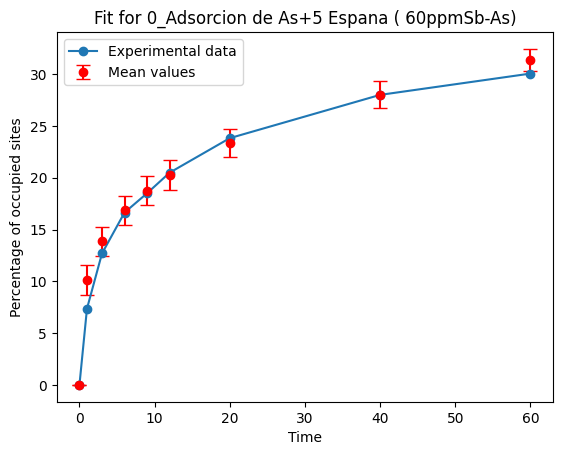

\n--- Optimizing for Experiment: 1_Adsorcion de As+5 Espana ( 60ppmAs-As) ---


Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:51<00:00,  1.93it/s, Mejor error=0.805703, P



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.08877026996230016, 'e_des': 0.10518628925212158, 'e_diff': 0.396, 'e_int_abs': 0.07574496363529731, 'e_int_des': 0.6524558588435664, 'lattice_size': np.int64(91), 'T': 311.85400461876935}
🔹 Error mínimo encontrado: 0.8057028818705897
⏳ Tiempo total de ejecución: 51.73 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.08877026996230016, 'e_des': 0.10518628925212158, 'e_diff': 0.396, 'e_int_abs': 0.07574496363529731, 'e_int_des': 0.6524558588435664, 'lattice_size': np.int64(91), 'T': 311.85400461876935}
\n--- Plotting fit for 1_Adsorcion de As+5 Espana ( 60ppmAs-As) ---
Mean values:  [ 0.         18.53785775 24.81632653 29.62081874 32.50235479 34.62576983
 39.24670933 45.8007487  49.90315179]
Standard deviation values:  [0.         1.94094822 1.7418769  1.80932919 1.62889511 1.65868018
 1.3295725  1.17952654 1.03974552]
Mean Squared Error (MSE): 4.103608019505198


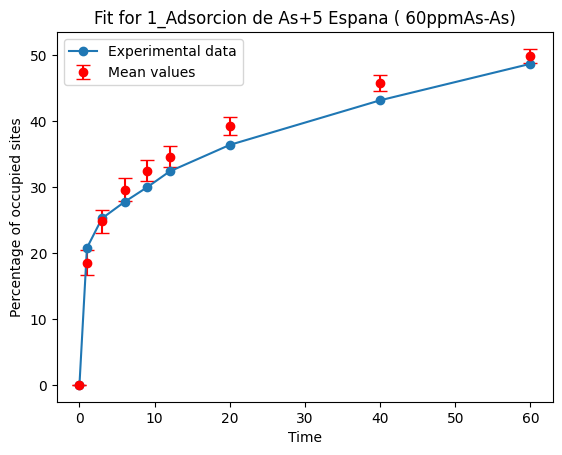

\n--- Optimizing for Experiment: 2_Adsorcion de As+5 Espana ( 90ppmAs-As) ---


Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:55<00:00,  1.80it/s, Mejor error=0.237040, P



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.09831596938920072, 'e_des': 0.11000000000000001, 'e_diff': 0.396, 'e_int_abs': 0.07700000000000001, 'e_int_des': 0.77, 'lattice_size': np.int64(100), 'T': 318.03522636902323}
🔹 Error mínimo encontrado: 0.237039680130406
⏳ Tiempo total de ejecución: 55.53 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.09831596938920072, 'e_des': 0.11000000000000001, 'e_diff': 0.396, 'e_int_abs': 0.07700000000000001, 'e_int_des': 0.77, 'lattice_size': np.int64(100), 'T': 318.03522636902323}
\n--- Plotting fit for 2_Adsorcion de As+5 Espana ( 90ppmAs-As) ---
Mean values:  [ 0.     16.4818 22.1684 26.7334 29.6734 31.9972 36.2026 42.6882 46.747 ]
Standard deviation values:  [0.         1.24520909 1.56711663 1.54748593 1.33193523 1.14404945
 1.11922315 0.9968147  0.90923886]
Mean Squared Error (MSE): 0.33020112726151934


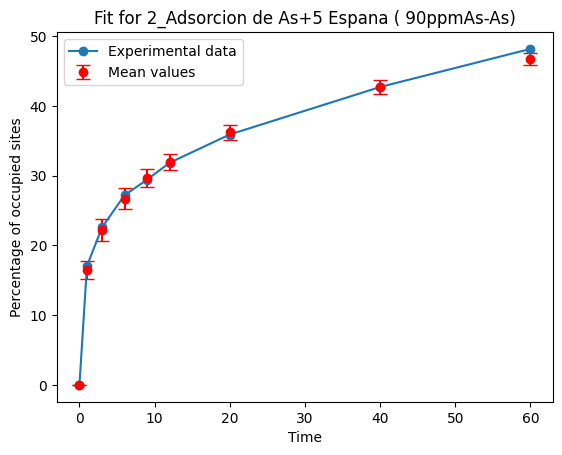

\n--- Optimizing for Experiment: 3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb) ---


Optimización Bayesiana en Progreso:  22%|▏| 22/100 [00:04<00:22,  3.52it/s, Mejor error=228.402967, /Users/gtorres/Desktop/proyecto/.venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.099, 0.09000000000000001, 0.396, 0.07700000000000001, 0.77, np.int64(100), 280.0] before, using random point [0.09599157943564623, 0.10871079723727023, 0.37271166908811415, 0.06517883032068807, 0.6567342774488958, np.int64(91), 291.63068954647633]
  warnings.warn(
Optimización Bayesiana en Progreso:  25%|▎| 25/100 [00:05<00:22,  3.40it/s, Mejor error=228.402967, /Users/gtorres/Desktop/proyecto/.venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.099, 0.09000000000000001, 0.396, 0.07700000000000001, 0.77, np.int64(100), 280.0] before, using random point [0.08361944845885869, 0.09832150231241527, 0.33054496088258534, 0.07511515189910525, 0.6366761166285875, np.in


✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.099, 'e_des': 0.09000000000000001, 'e_diff': 0.396, 'e_int_abs': 0.07700000000000001, 'e_int_des': 0.77, 'lattice_size': np.int64(100), 'T': 280.0}
🔹 Error mínimo encontrado: 228.40296715515439
⏳ Tiempo total de ejecución: 52.52 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.099, 'e_des': 0.09000000000000001, 'e_diff': 0.396, 'e_int_abs': 0.07700000000000001, 'e_int_des': 0.77, 'lattice_size': np.int64(100), 'T': 280.0}
\n--- Plotting fit for 3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb) ---
Mean values:  [ 0.      9.2502 12.6982 15.3966 17.1832 18.6094 21.3996 25.255  28.192 ]
Standard deviation values:  [0.         1.72812449 1.84361523 1.99980061 1.70846684 1.8844459
 1.569067   1.76753403 1.82693454]
Mean Squared Error (MSE): 234.59293413648325


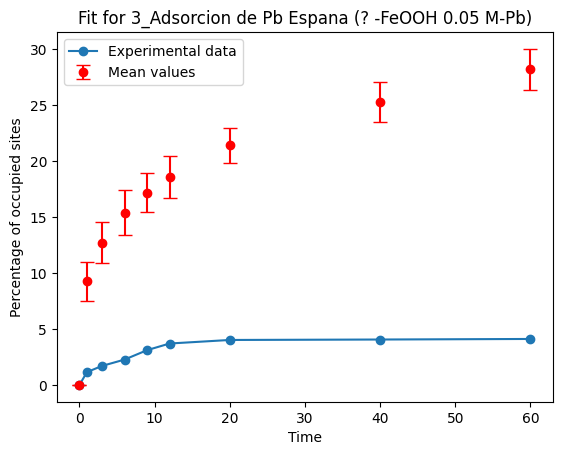

\n--- Optimizing for Experiment: 4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb) ---


Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:45<00:00,  2.21it/s, Mejor error=4.229105, P



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.099, 'e_des': 0.1044169016911635, 'e_diff': 0.396, 'e_int_abs': 0.07700000000000001, 'e_int_des': 0.63, 'lattice_size': np.int64(100), 'T': 280.0}
🔹 Error mínimo encontrado: 4.2291054797787355
⏳ Tiempo total de ejecución: 45.21 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.099, 'e_des': 0.1044169016911635, 'e_diff': 0.396, 'e_int_abs': 0.07700000000000001, 'e_int_des': 0.63, 'lattice_size': np.int64(100), 'T': 280.0}
\n--- Plotting fit for 4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb) ---
Mean values:  [ 0.     10.1014 13.9662 16.9452 18.727  20.1578 22.8446 27.0992 29.719 ]
Standard deviation values:  [0.         1.88414005 1.72919338 1.42949719 1.79226029 1.80902419
 1.96382614 1.79796692 1.92133696]
Mean Squared Error (MSE): 24.83461353209967


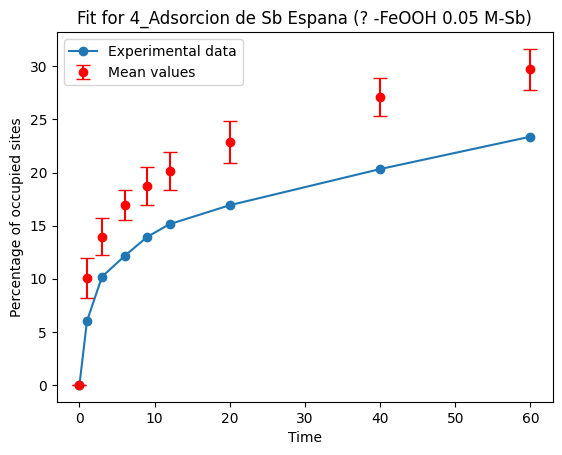

\n--- Optimizing for Experiment: 5_Adsorcion de Sb Espana ( 60ppmSb-Sb) ---


Optimización Bayesiana en Progreso:  77%|▊| 77/100 [00:37<00:18,  1.22it/s, Mejor error=15.769337, P

KeyboardInterrupt: 

In [7]:
import numpy as np
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm
import matplotlib.pyplot as plt # Added for plotting fits later

# --- Assume the following are defined from previous cells in the notebook ---
# data: pandas DataFrame with experimental data
# KineticMonteCarlo: class definition
# KMCModelOptimizer: class definition
# run_multiple_simulations: function definition (optional, for plotting fits)
# --------------------------------------------------------------------------

# Define variability percentage for parameter ranges (adjust as needed)
variability_percentage = 0.1 # 10% variability

# Central parameter values (you might adjust these starting points or ranges)
central_processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.1, "e_int_des": 0.7},
    "diffusion": {"e_diff": 0.36}
}
central_T = 300
central_lattice_size = 70

# --- Store results for all experiments ---
all_results = []
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60]) # Assuming this is the time array for all experiments

# --- Loop through each experimental dataset ---
for i in range(len(data)):
    experiment_label = data.iloc[i]['Fuente(experimento)'] # Get the label
    exp_data_points = data.iloc[i, :9].to_numpy() # Get data points (assuming first 9 columns are data)

    print(f"\\n--- Optimizing for Experiment: {experiment_label} ---")

    # --- Define parameter ranges for the current optimization ---
    # You might want different ranges per experiment, but here we use the same base
    param_ranges = {
        'e_ads': [central_processes["adsorption"]["e_ads"] * (1 - variability_percentage),
                  central_processes["adsorption"]["e_ads"] * (1 + variability_percentage)],
        'e_des': [central_processes["desorption"]["e_des"] * (1 - variability_percentage),
                  central_processes["desorption"]["e_des"] * (1 + variability_percentage)],
        'e_diff': [central_processes["diffusion"]["e_diff"] * (1 - variability_percentage),
                   central_processes["diffusion"]["e_diff"] * (1 + variability_percentage)],
        'e_int_abs': [central_processes["adsorption"]["e_int_abs"] * (1 - variability_percentage),
                      central_processes["adsorption"]["e_int_abs"] * (1 + variability_percentage)],
        'e_int_des': [central_processes["desorption"]["e_int_des"] * (1 - variability_percentage),
                      central_processes["desorption"]["e_int_des"] * (1 + variability_percentage)],
        'lattice_size': [50, 100],  # Keep this range or adjust
        'T': [280, 350]             # Keep this range or adjust
    }

    # --- Execute the optimization for the current curve ---
    # Note: n_calls might need adjustment based on desired accuracy vs. time
    optimizer = KMCModelOptimizer(exp_data_points, param_ranges, n_calls=100) # Use current exp_data_points
    optimizer.optimize() # Runs the optimization and prints results for this curve

    # --- Store the best results for this curve ---
    if optimizer.best_params:
        current_result = {
            'experiment': experiment_label,
            'best_params': optimizer.best_params,
            'min_error': optimizer.best_error
        }
        all_results.append(current_result)

        # --- Optional: Plot the fit for the current curve ---
        # You might want to put plotting in a separate loop after all optimizations
        # Or call run_multiple_simulations here with the best params found
        print(f"\\n--- Plotting fit for {experiment_label} ---")
        best_params_found = optimizer.best_params
        best_processes = {}
        if 'e_ads' in best_params_found:
             best_processes["adsorption"] = {"e_ads": best_params_found["e_ads"], "e_int_abs": best_params_found.get("e_int_abs", 0.1)} # Using default if not found
        if 'e_des' in best_params_found:
             best_processes["desorption"] = {"e_des": best_params_found["e_des"], "e_int_des": best_params_found.get("e_int_des", 0.7)} # Using default if not found
        if 'e_diff' in best_params_found:
             best_processes["diffusion"] = {"e_diff": best_params_found["e_diff"]}

        # Run multiple simulations with best params for smoother curve & error bars
        plt.figure() # Create a new figure for each plot
        run_multiple_simulations(N=50, # Number of KMC runs to average
                                  lattice_size=int(best_params_found['lattice_size']),
                                  T=best_params_found['T'],
                                  processes=best_processes,
                                  time_array=time_array,
                                  exp_data=exp_data_points)
        plt.title(f"Fit for {experiment_label}") # Add title specific to experiment
        plt.show() # Display the plot

    else:
         print(f"Optimization failed to find parameters for {experiment_label}")

# --- Print all results after the loop ---
print("\\n===========================================")
print("Optimization Results for All Experiments:")
print("===========================================")
for result in all_results:
    print(f"Experiment: {result['experiment']}")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Minimum MSE: {result['min_error']:.6f}\\n")

# You can also convert all_results to a pandas DataFrame for easier analysis
# results_df = pd.DataFrame(all_results)
# print(results_df)